<a href="https://colab.research.google.com/github/mmderakhshani/PascalVOC2007-Fastai/blob/master/ImageSegmentationUsingFastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.vision import *
from fastai.vision import *
import fastai

In [0]:
# Download Pascal VOC 2007 dataset
# !wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar

In [0]:
root = Path('./')
(root/'data').mkdir(parents=False, exist_ok=True)
root.ls()

[PosixPath('.config'),
 PosixPath('data'),
 PosixPath('VOCtrainval_06-Nov-2007.tar'),
 PosixPath('sample_data')]

In [0]:
# !tar -xvf VOCtrainval_06-Nov-2007.tar -C data/

In [0]:
path_img = (root/'data/VOCdevkit/VOC2007/JPEGImages')
path_lbl = (root/'data/VOCdevkit/VOC2007/SegmentationClass')

In [0]:
fnames = get_image_files(path_img)
path_trnval = root/'data/VOCdevkit/VOC2007/ImageSets/Segmentation/trainval.txt'
trnval_ids = np.loadtxt(path_trnval, dtype=str); print(trnval_ids)
# Removing non-annotated data
for f in fnames:
  if f.stem not in trnval_ids:
    print(f.stem)
    os.remove(f)

['000032' '000033' '000039' '000042' ... '009923' '009938' '009947' '009950']


In [0]:
fnames = get_image_files(path_img); print(len(fnames))
lbl_name = get_image_files(path_lbl); print(len(lbl_name))

422
422


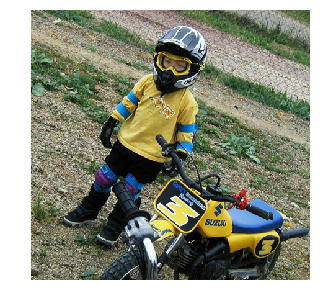

In [0]:
img_name = fnames[0]
img = open_image(img_name)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}.png'

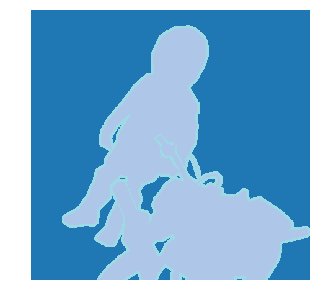

In [0]:
mask_name = get_y_fn(img_name)
mask = open_mask(mask_name, convert_mode='P')
mask.show(figsize=(5,5), alpha=1)

In [0]:
npy_arr = mask.data.numpy()
np.unique(npy_arr)

array([  0,  14,  15, 255])

In [0]:
codes = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'];
len(codes)

21

In [0]:
src_size = np.array(mask.shape[1:]);
print(src_size)

[435 450]


In [0]:
class SegmentationProcessor(PreProcessor):
    "`PreProcessor` that stores the classes for segmentation."
    def __init__(self, ds:ItemList): self.classes = ds.classes
    def process(self, ds:ItemList):  ds.classes,ds.c = self.classes,len(self.classes)
      
class SegmentationLabelList(ImageItemList):
    "`ItemList` for segmentation masks."
    _processor=SegmentationProcessor
    def __init__(self, items:Iterator, classes:Collection=None, **kwargs):
        super().__init__(items, **kwargs)
        self.classes,self.loss_func = classes,CrossEntropyFlat(axis=1)

    def new(self, items, classes=None, **kwargs):
        return self.new(items, ifnone(classes, self.classes), **kwargs)

    def open(self, fn): return open_mask(fn,convert_mode='P')   #HERE
    def analyze_pred(self, pred, thresh:float=0.5): return pred.argmax(dim=0)[None]
    def reconstruct(self, t:Tensor): return ImageSegment(t)
    
class SegmentationItemList(ImageItemList):
    "`ItemList` suitable for segmentation tasks."
    _label_cls,_square_show_res = SegmentationLabelList,False

In [0]:
# size_np = src_size//2
# size = (int(size_np[0]), int(size_np[1]))
size = 224
bs= 8

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .random_split_by_pct()
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

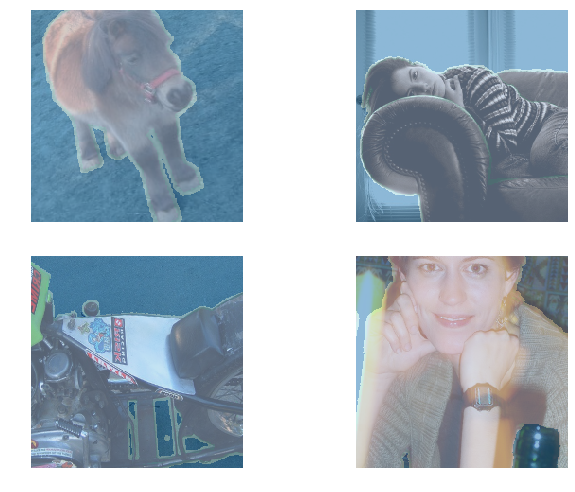

In [0]:
data.show_batch(2, figsize=(10,7))

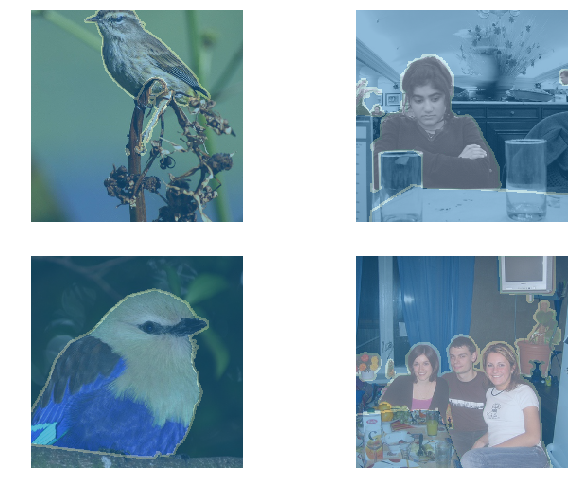

In [0]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [0]:
wd=1e-2

In [0]:
def custom_loss(y_hat,y):
    y = y.squeeze(1)
    loss = nn.CrossEntropyLoss(ignore_index=255)
    return loss(y_hat,y)

def custom_acc(input,targs):
    targs = targs.squeeze(dim=1)
    input = input.argmax(dim=1)
    
    return (input.flatten()==targs.flatten()).float().mean()

In [0]:
learn = unet_learner(data, 
                     models.resnet34,
                     metrics=custom_acc,
                     loss_func=custom_loss, 
                     wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


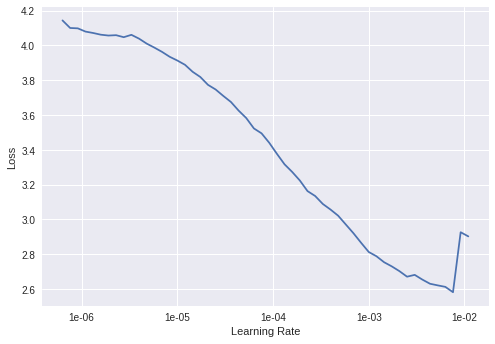

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-4

In [0]:
learn.fit_one_cycle(14, max_lr=lr, pct_start=0.4)

epoch,train_loss,valid_loss,custom_acc
1,3.152125,2.320462,0.548228
2,2.191447,1.547759,0.638445
3,1.643539,1.248224,0.668335
4,1.366132,1.550983,0.606654
5,1.219852,1.091869,0.700613
6,1.082919,0.936574,0.720922
7,1.017342,0.933881,0.718288
8,0.918922,0.891033,0.725015
9,0.837703,0.802973,0.732554
10,0.765049,0.758968,0.741629


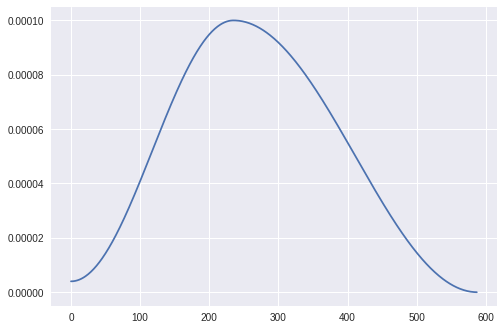

In [0]:
learn.recorder.plot_lr()

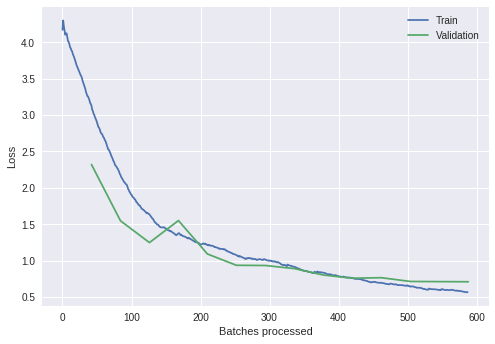

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

In [0]:
# learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


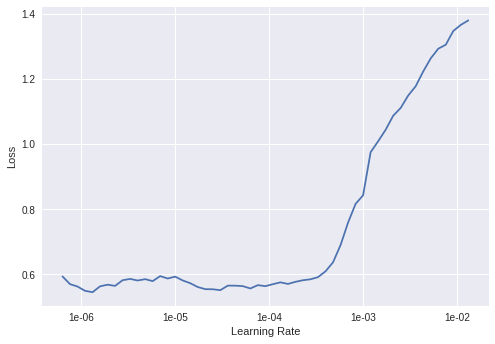

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 5e-5
lrs = slice(lr/4,lr)
learn.fit_one_cycle(8, lrs, pct_start=0.3)

epoch,train_loss,valid_loss,custom_acc
1,0.578167,0.714573,0.750393
2,0.577846,0.760948,0.745896
3,0.582552,0.755509,0.754223
4,0.567835,0.701044,0.753476
5,0.544877,0.644988,0.766658
6,0.476975,0.630243,0.772917
7,0.427475,0.628183,0.775398
8,0.398235,0.621598,0.777321


In [0]:
learn.save('stage-2')

In [0]:
size = 448
bs= 3

src = (SegmentationItemList.from_folder(path_img)
       .random_split_by_pct()
       .label_from_func(get_y_fn, classes=codes))

data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, 
                     models.resnet34,
                     metrics=custom_acc,
                     loss_func=custom_loss, 
                     wd=wd)
learn.load('stage-2');

epoch,train_loss,valid_loss,custom_acc


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


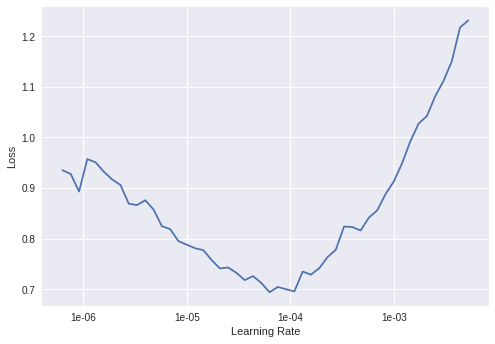

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr = 5e-6
learn.fit_one_cycle(10, lr, pct_start=.4)

epoch,train_loss,valid_loss,custom_acc
1,0.851730,0.446822,0.813720
2,0.782882,0.458998,0.810271
3,0.713196,0.454522,0.811457
4,0.758099,0.491084,0.804472
5,0.760449,0.466061,0.806859
6,0.664337,0.449827,0.811321
7,0.668296,0.456167,0.810761
8,0.669744,0.467316,0.809986
9,0.627178,0.457065,0.810962
10,0.666945,0.458381,0.811763


In [0]:
learn.save('stage-3')
learn.load('stage-3');

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10, max_lr=slice(lr/100,lr/10), pct_start=.3)

epoch,train_loss,valid_loss,custom_acc
1,0.635507,0.454234,0.813627
2,0.674985,0.452230,0.812505
3,0.671363,0.453045,0.812131
4,0.604635,0.453779,0.811852
5,0.723080,0.445548,0.815181
6,0.682730,0.443229,0.816286
7,0.725207,0.457598,0.810665
8,0.632698,0.441833,0.814827
9,0.656818,0.447877,0.813855
10,0.648760,0.453837,0.811147


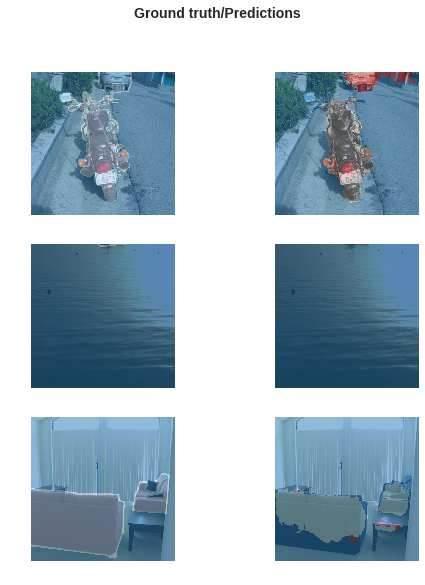

In [0]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
img = learn.data.valid_ds[2][0]

In [0]:
img.shape

torch.Size([3, 448, 448])

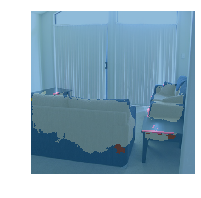

In [0]:
img.show(y=learn.predict(img)[0])

In [0]:
learn.predict(img)[0].shape

torch.Size([1, 448, 448])